**Custumized UNet on Coronadataset**

This notebook contains the custumizeed UNet from the keras_unet libary. The UNet is trained on a dataset which contains images of lungs that are infect with Corona. 

To get the data you have to open the zip orders on your own machine. 

The jupyter notebook is inspired from the following github site:
https://github.com/karolzak/keras-unet/tree/203f6b6bfc3eda699fcac7fc3ef7c8186189a67b

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

import nibabel as nib
from nilearn import image
from nibabel.testing import data_path

from pathlib import Path
from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD

from keras_unet.utils import plot_imgs
from keras_unet.utils import get_augmented
from keras_unet.utils import plot_segm_history

from keras_unet.models import custom_unet
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

from skimage.color import rgb2gray

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## Functions for plotting the images. This function can also handle mask with diffferent classes

In [2]:
def mask_overlay(mask_im, desired_size ):
    
    pad = (desired_size - mask_im.shape[0]) // 2
    mask = np.pad(mask_im, pad, mode="constant")
    mask_gray = rgb2gray(mask)

    h = mask_gray.shape[0]
    w = mask_gray.shape[1]
    zeros = np.zeros((h, w))
    ones = mask_gray.reshape(h, w)
    return np.stack((ones, zeros, zeros, ones), axis=-1)

In [3]:
def plot_img_classes(org_imgs, mask_imgs, pred_imgs=None, nm_img_to_plot=10, figsize=4,alpha=0.5):
    
    if nm_img_to_plot > org_imgs.shape[0]:
            nm_img_to_plot = org_imgs.shape[0]
    im_id = 0
    org_imgs_size = org_imgs.shape[1]

    org_imgs = np.squeeze(org_imgs)

    if (pred_imgs is None):
        cols = 3
    else:
        cols = 4

    fig, axes = plt.subplots(
        nm_img_to_plot, cols, figsize=(cols * figsize, nm_img_to_plot * figsize)
    )
    axes[0, 0].set_title("original", fontsize=15)
    axes[0, 1].set_title("ground truth", fontsize=15)
    
    if not (pred_imgs is None):
        axes[0, 2].set_title("prediction", fontsize=15)
        axes[0, 3].set_title("overlay", fontsize=15)
    else:
        axes[0, 2].set_title("overlay", fontsize=15)
        
    for m in range(0, nm_img_to_plot):
        axes[m, 0].imshow(org_imgs[im_id], cmap="gray")
        axes[m, 0].set_axis_off()
        axes[m, 1].imshow(mask_imgs[im_id], cmap="gray")
        axes[m, 1].set_axis_off()
        if not (pred_imgs is None):
            axes[m, 2].imshow(pred_imgs[im_id], cmap="gray")
            axes[m, 2].set_axis_off()
            axes[m, 3].imshow(org_imgs[im_id], cmap="gray")
            axes[m, 3].imshow(
                mask_overlay(pred_imgs[im_id], desired_size=org_imgs_size),
                 alpha=alpha)
            axes[m, 3].set_axis_off()
        else:
            axes[m, 2].imshow(org_imgs[im_id], cmap="gray")
            axes[m, 2].imshow(
                 mask_overlay(mask_imgs[im_id], desired_size=org_imgs_size),
                cmap="gray", alpha=alpha)
            axes[m, 2].set_axis_off()
        im_id += 1

    plt.show()

## Load data

In [4]:
PATH_gt = str(Path.cwd()/'tr_im.nii')
PATH_mask = str(Path.cwd()/'tr_mask.nii')

def getData(PATH):
    #as to get the slices to prodcue 2D images from a 3D image dataset
    a = nib.load(PATH)
    a = a.get_fdata()
    
    slices = []    
    for i in range(a.shape[2]):
        slices.append((a[:,:,i]))
    slices = slices[::-1]
    slices = np.asarray(slices)
   
    
    return slices, a.shape[2]
train_im, sample_size_tr = getData(PATH_gt)
mask_im, sample_size_ma = getData(PATH_mask)

## Plot the data

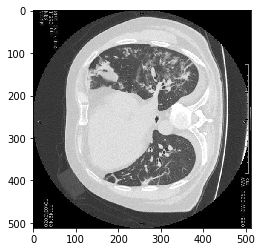

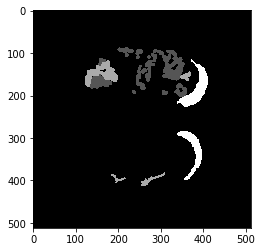

In [5]:
plt.imshow(train_im[0], cmap = "gray")
plt.show()

plt.imshow(mask_im[0], cmap ="gray")
plt.show()

## Plot images + masks + overlay (mask over original)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


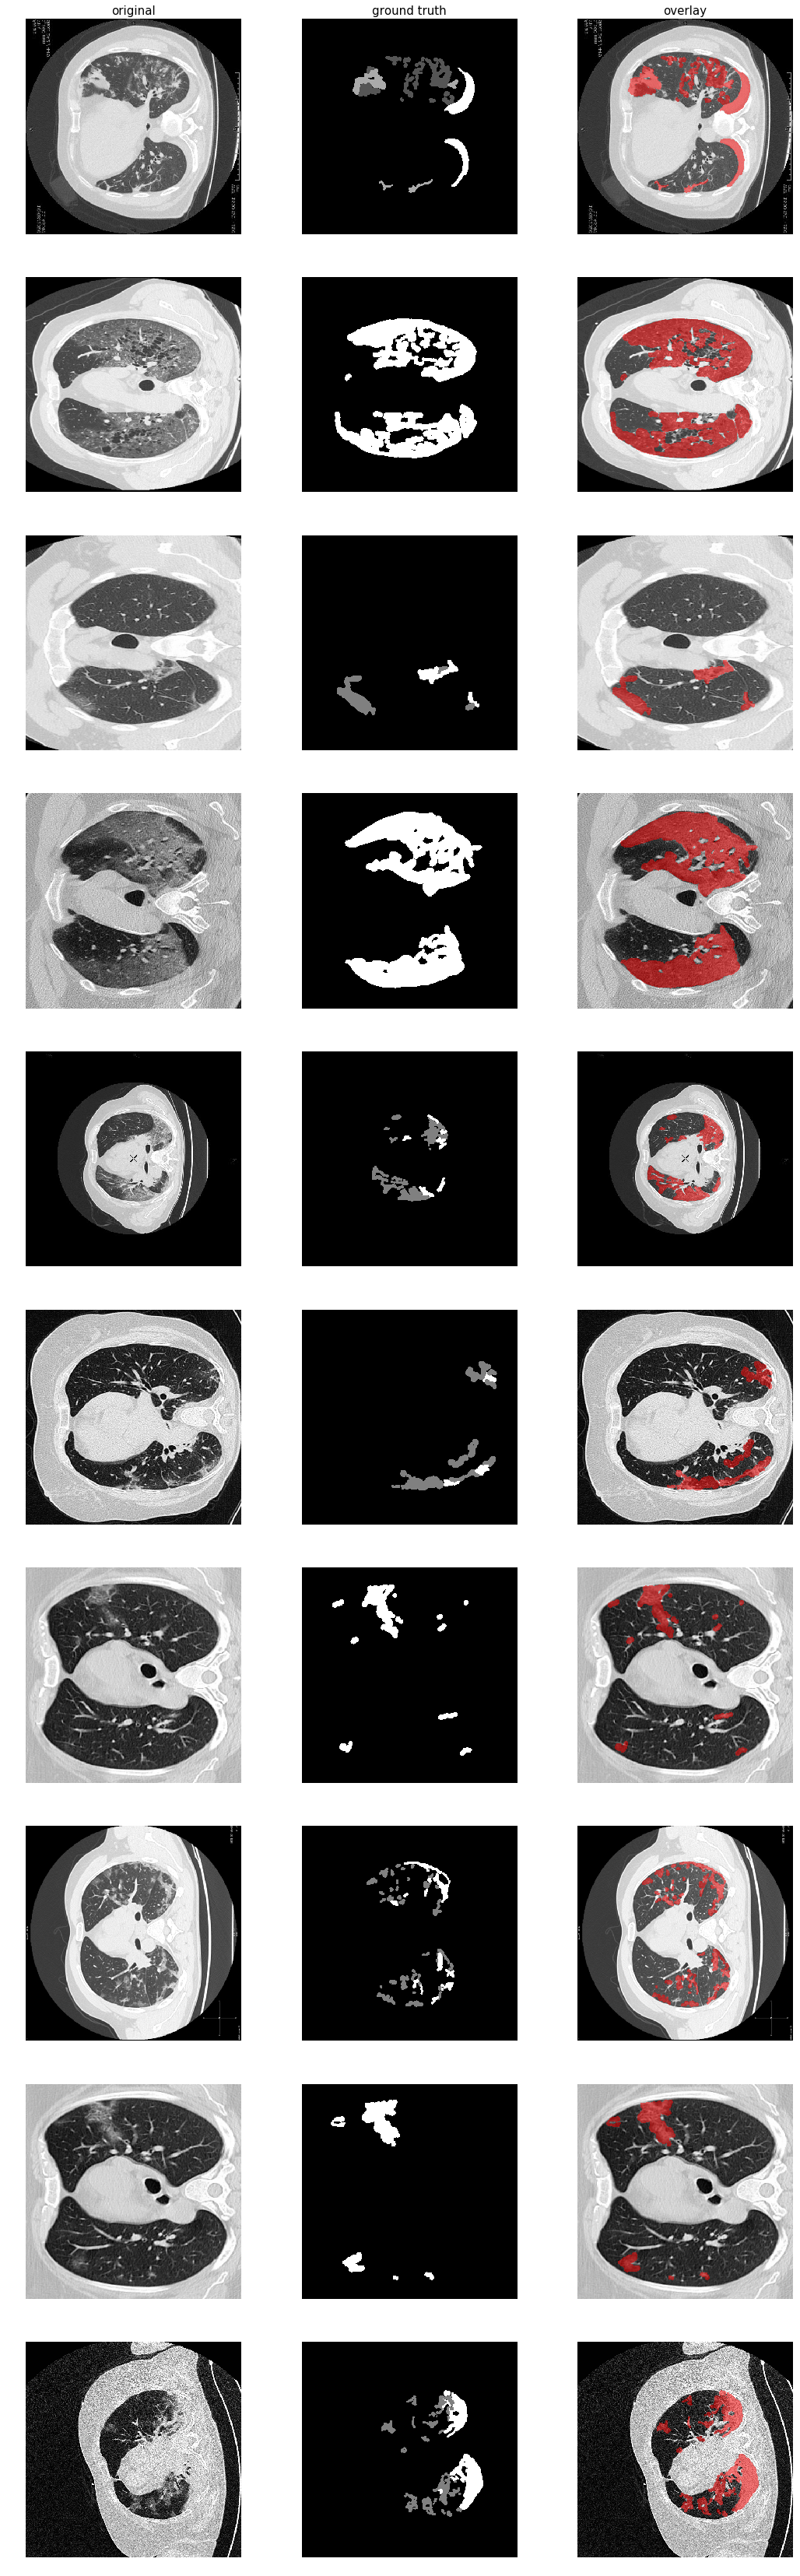

In [6]:
plot_imgs(org_imgs=train_im, mask_imgs=mask_im, nm_img_to_plot=10, figsize=6)

## Get data into correct shape, seperate the different classes, dtype and normalized

In [7]:
#add 1680 to get all values in a positive range for normalization 
train_trans = train_im + 1680
train = np.asarray(train_trans, dtype=np.float32)/train_trans.max()
train = train.reshape(100,512,512, 1)

In [13]:
#get the classes seperated
classes = [1,2,3]

masks = [(mask_im == v) for v in classes]
mask = np.stack(masks, axis=-1).astype('float')
#mask = mask_im.reshape(100,512,512, 1)
 # add background if mask is not binary
if mask.shape[-1] != 1:
    background = 1 - mask.sum(axis=-1, keepdims=True)
    mask = np.concatenate((mask, background), axis=-1)


In [14]:
print("mask", mask.max(),  mask.min(), "train",train.max(),train.min())


mask 1.0 0.0 train 1.0 0.03225837


##  Train/val split

In [15]:
#split the training data since we don't have a validation dataset
x_train, x_val, y_train, y_val = train_test_split(train, mask, test_size=0.3, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)


x_train:  (70, 512, 512, 1)
y_train:  (70, 512, 512, 4)
x_val:  (30, 512, 512, 1)
y_val:  (30, 512, 512, 4)


## Prepare train generator with data augmentation

In [16]:
train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

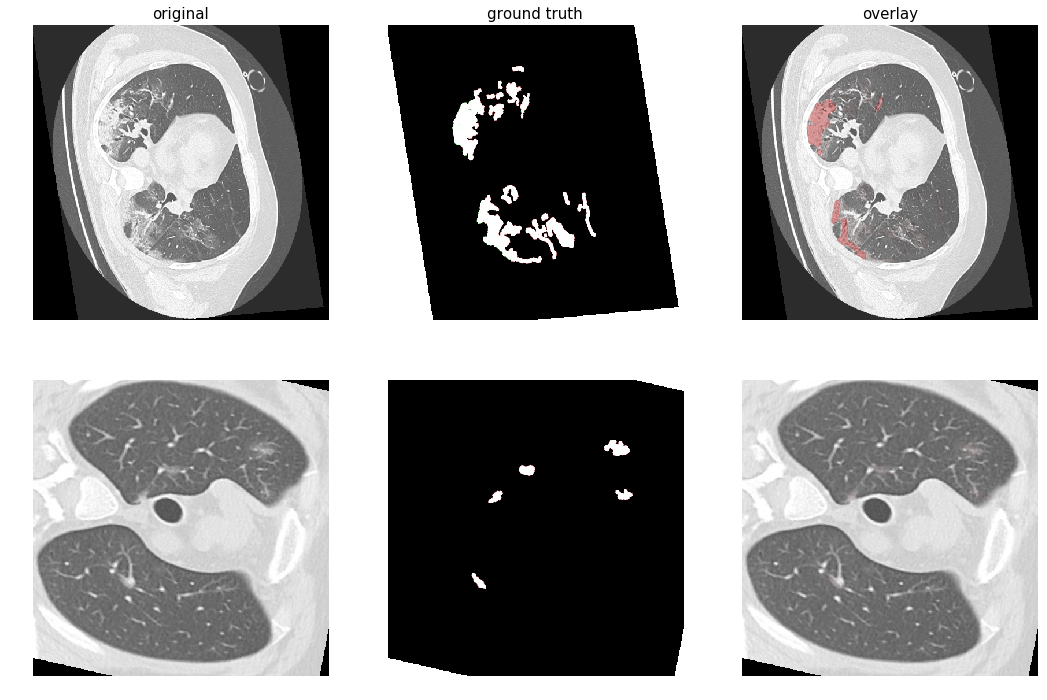

In [17]:
sample_batch = next(train_gen)
xx, yy = sample_batch
plot_img_classes(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)
#plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

## Initialize network

In [26]:
input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    use_batch_norm=True,
    num_classes=4,
    filters=64,
    #use_attention=True,
    output_activation='softmax',
)

In [ ]:
#model.summary()

## Compile + train

In [19]:
model_filename = 'segm_model_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [28]:
model.compile(
    optimizer=Adam(lr=0.001), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)


In [29]:
history = model.fit(
    train_gen,
    steps_per_epoch=200,
    epochs=5,
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

Epoch 1/5
200/200 [==============================] - ETA: 0s - loss: 0.2046 - iou: 0.5754 - iou_thresholded: 0.7723 
Epoch 00001: val_loss did not improve from 1.89516
200/200 [==============================] - 10514s 53s/step - loss: 0.2046 - iou: 0.5754 - iou_thresholded: 0.7723 - val_loss: 4.0666 - val_iou: 0.0741 - val_iou_thresholded: 0.0609
Epoch 2/5
200/200 [==============================] - ETA: 0s - loss: 0.1557 - iou: 0.6580 - iou_thresholded: 0.8232 
Epoch 00002: val_loss improved from 1.89516 to 0.23343, saving model to segm_model_v0.h5
200/200 [==============================] - 8287s 41s/step - loss: 0.1557 - iou: 0.6580 - iou_thresholded: 0.8232 - val_loss: 0.2334 - val_iou: 0.5642 - val_iou_thresholded: 0.6396
Epoch 3/5
200/200 [==============================] - ETA: 0s - loss: 0.1454 - iou: 0.6718 - iou_thresholded: 0.8338 
Epoch 00003: val_loss improved from 0.23343 to 0.14361, saving model to segm_model_v0.h5
200/200 [==============================] - 8086s 40s/step -

## Plot training history

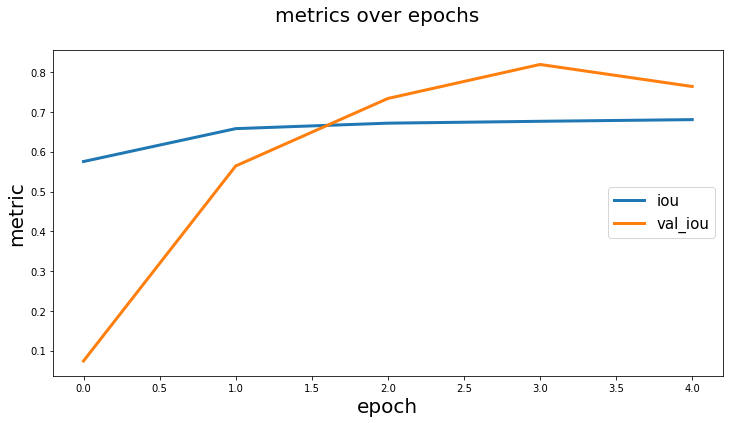

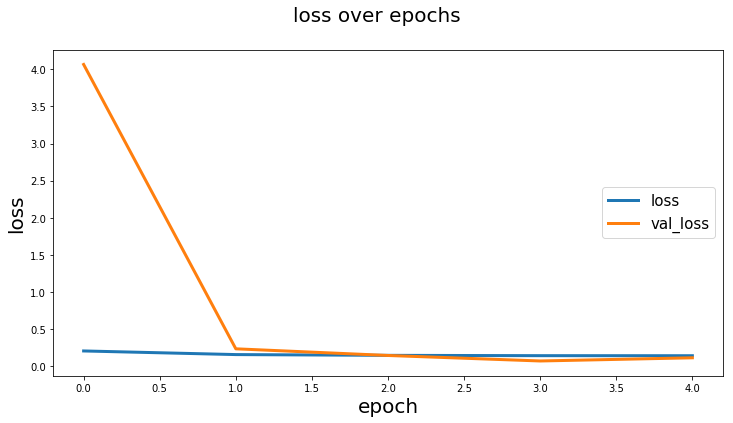

In [30]:
plot_segm_history(history)

## Plot original + ground truth + pred 

In [31]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)

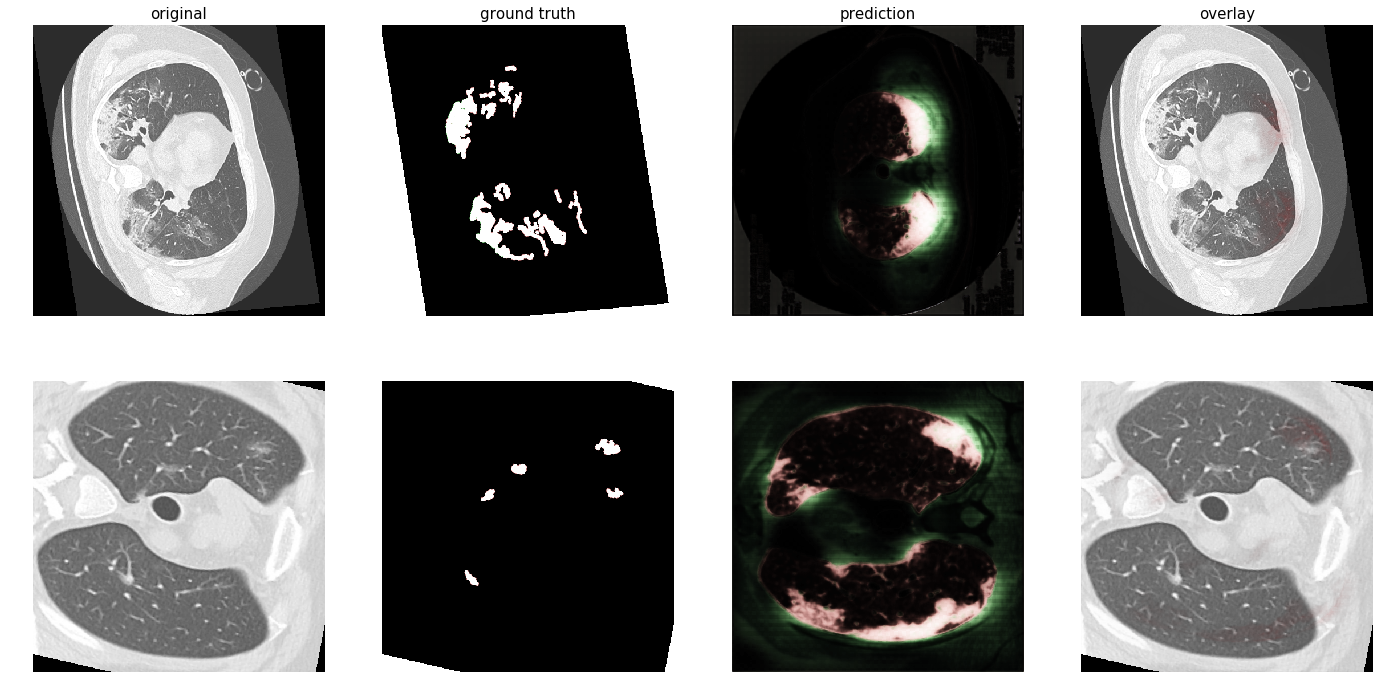

In [32]:
plot_img_classes(org_imgs=xx, mask_imgs=yy, pred_imgs= y_pred,nm_img_to_plot=2, figsize=6)
#plot_imgs(org_imgs=xx, mask_imgs=yy, pred_imgs= y_pred,nm_img_to_plot=2, figsize=6)